In [1]:
# setup
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
display(HTML(open('rise.css').read()))

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})


# CMPS 2200
# Introduction to Algorithms

## Parallelism (Cont'd)
 

## Parallelism (aka parallel computing)

> ability to run multiple computations at the same time

- faster
- lower energy usage
  + energy consumption is a cubic function of clock frequency
- better hardware now available
  + multicore processors & GPUs
  
  
The **speedup** of a parellel algorithm $P$ over a sequential algorithms $S$ is:
$$
speedup(P,S) = \frac{T(S)}{T(P)}
$$

  

## Example: Summing a list

Summing can easily be parallelised by splitting the input list into two (or $k$) pieces.

```python
def sum_list(mylist):
    result = 0
    for v in mylist:
        result += v
    return result

```
#### What is the cost?
> assume the the length of mylist is $n$


```python
from multiprocessing.pool import ThreadPool

def parallel_sum_list(mylist):
    result1, result2 = in_parallel(
        sum_list, mylist[:len(mylist)//2],
        sum_list, mylist[len(mylist)//2:]
    )
    # combine results
    return result1 + result2
def in_parallel(f1, arg1, f2, arg2):
    with ThreadPool(2) as pool:
        result1 = pool.apply_async(f1, [arg1])  # launch f1
        result2 = pool.apply_async(f2, [arg2])  # launch f2
        return (result1.get(), result2.get())   # wait for both to finish  
```


>`parallel_sum_list` is almost twice as fast `sum_list` 
$O(\frac{n}{2}) + O(1)$, where $O(1)$ to combine results






## divide and conquer

**idea**: 
- let threads create threads recursively https://www.programiz.com/python-programming/recursion
- parallelize combination steps


![dag-sum](figures/dag-sum1.png)  
[source](https://homes.cs.washington.edu/~djg/teachingMaterials/spac/sophomoricParallelismAndConcurrency.pdf)


In [3]:
# recursive, serial
def sum_list_recursive(mylist):    
    print('summing %s' % mylist)
    if len(mylist) == 1:
        return mylist[0]
    return (
        sum_list_recursive(mylist[:len(mylist)//2]) +
        sum_list_recursive(mylist[len(mylist)//2:])
    )

sum_list_recursive(range(10))

summing range(0, 10)
summing range(0, 5)
summing range(0, 2)
summing range(0, 1)
summing range(1, 2)
summing range(2, 5)
summing range(2, 3)
summing range(3, 5)
summing range(3, 4)
summing range(4, 5)
summing range(5, 10)
summing range(5, 7)
summing range(5, 6)
summing range(6, 7)
summing range(7, 10)
summing range(7, 8)
summing range(8, 10)
summing range(8, 9)
summing range(9, 10)


45

In [6]:
# recursive, parallel
def sum_list_recursive_parallel(mylist):    
    print('summing %s' % mylist)
    if len(mylist) == 1:
        return mylist[0]
    
    # each thread spawns more threads
    result1, result2 = in_parallel(
        sum_list_recursive_parallel, mylist[:len(mylist)//2],
        sum_list_recursive_parallel, mylist[len(mylist)//2:]
    )
    print('>>>merging %s and %s' % (result1, result2))
    return result1 + result2

sum_list_recursive_parallel(range(10))

summing range(0, 10)
summing range(0, 5)
summing range(5, 10)
summing range(0, 2)
summing range(2, 5)
summing range(5, 7)
summing range(7, 10)
summing range(0, 1)
summing range(1, 2)
summing range(2, 3)
summing range(3, 5)
summing range(5, 6)
summing range(6, 7)
summing range(7, 8)
summing range(8, 10)
>>>merging 0 and 1
>>>merging 5 and 6
summing range(3, 4)
summing range(4, 5)
>>>merging 3 and 4
summing range(8, 9)
summing range(9, 10)
>>>merging 2 and 7
>>>merging 8 and 9
>>>merging 7 and 17
>>>merging 1 and 9
>>>merging 11 and 24
>>>merging 10 and 35


45

## Analyzing parallel algorithms

> **work**: total number of primitive operations performed by an algorithm

- For sequential machine, just total sequential time.
- On parallel machine, work is divided among $P$ processors

> **perfect speedup**: dividing $W$ work across $P$ processors yields total time $\frac{W}{P}$

> **span**: longest sequence of dependencies in computation
- time to run with an infinite number of processors
- measure of how "parallelized" an algorithm is 
- also called: *critical path length* or *computational depth*


## Intuition
>**work**: total energy consumed by a computation  
>**span**: minimum possible time that the computation requires

<br><br>      
        
>**work**: $T_1$ = time using one processor  
>**span**: $T_\infty$ = time using $\infty$ processors

> **parallelism** = $\frac{T_1}{T_\infty}$  
> maximum possible speedup with unlimited processors

## Computation Graph

![dag](figures/dag.png)  
[source](https://homes.cs.washington.edu/~djg/teachingMaterials/spac/sophomoricParallelismAndConcurrency.pdf)

- Directed-acyclic graph (DAG) where
  - Each node is a unit of computation $(O(1))$
  - An edge is a **computational dependency**
    - Edge from node $A$ and $B$ means $A$ must complete before $B$ begins
    
> **work**: total number of primitive operations performed by an algorithm  
> **span**: longest sequence of dependencies in computation



#### So, what is work and span for `sum_list_recursive_parallel`? 

**work**: number of nodes

**span**: length of longest path

What is the height of a balanced binary tree with $n$ nodes?

> $O(\log_2 n)$


- Number of leaf nodes in a perfect binary tree is $2^h$.
- To add an array of length $n$, the computation graph has $2 * 2^{(\log_2 n)} +n = 3n$ nodes.

<br>

so, 

**work**: $3n \in O(n)$  
**span**: $2 \log_2 n \in O(\log_2 n)$

<br>

**parallelism**: $O(\frac{n}{\log_2 n})$ = **exponential speedup**

<br><br>

### Work Efficiency

> A parallel algorithm is (asymptotically) **work efficient** if the work is asymptotically the same as the time for an optimal sequential algorithm that solves the same problem.

Since $T_{\hbox{sequential}} = T_1 = O(n)$, our parallel algorithm is work efficient

## Using $p$ processors

Of course, we don't have $\infty$ processors. What if we only have $p$?

It can be shown that (and will be shown in lecture 4):

$T_p \leq \frac{T_1}{p} + T_\infty$  
$T_p \in O(\frac{T_1}{p} + T_\infty)$

So, assuming $\log_2 n$ processors, our parallel sum algorithm has time

$O(\frac{n}{\log_2 n} + \log_2 n)$

compared to $O(n)$ of serial algorithm.



## Amdahl's Law

As seen above, some parts of parallel algorithms are sequential.

We expect that the bigger the "sequential" part of the parallel algorithm is, the lower its speedup.

How bad is a little bit of sequential code?


- Let $T_1$ be the total time of the parallel algorithm on one processor. Let's set this value to 1.
- Let $S$ be the amount of time that cannot be parallelized.
- Assume (generously) that the remaining time (1-S) gets perfect speedup using $p$ processors.
- Then we have

$T_1 = S + (1-S) = 1$  
$T_P = S + \frac{(1-S)}{p}$


<br><br>
**Amdahl's Law**

$$\frac{T_1}{T_p} = \frac{1}{S + \frac{1 − S}{p}}$$

speedup using $p$ processors is limited by the fraction of the algorithm that is parallelizable.

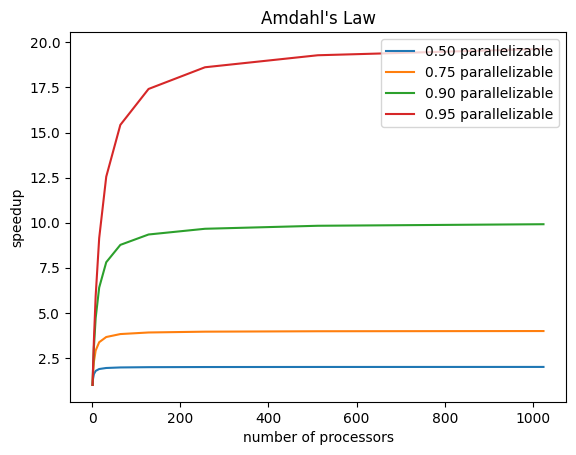

In [8]:
# plot amdahl's law
import matplotlib.pyplot as plt
processors = [1,2,4,8,16,32,64,128,256,512,1024]
parallel_portions = [.5, .75, .9, .95]
plt.figure()
for parallel_portion in parallel_portions:
    S = 1 - parallel_portion
    speedups = [1 / (S + (1-S)/p) for p in processors]
    plt.plot(processors, speedups, label='%.2f parallelizable' % parallel_portion)
plt.legend()
plt.ylabel('speedup')
plt.xlabel('number of processors')
plt.title("Amdahl's Law")
plt.show()
        

If 95% of the program can be parallelized, the theoretical maximum speedup using parallel computing would be 20 times.

If 50% of the program can be parallelized, the theoretical maximum speedup using parallel computing would be 2 times.

**even if you have a billion processors!**

**Reasons for hope:**

As number of processors grow, span becomes more important than work.
- scalability matters more than performance
- we can tradeoff work and span in algorithm choice

Allows us to do new things we couldn't do before:
- consider **computer graphics**: rendering many pixels in parallel allows more accurate images